# Basic analysis of a single ACCESS-OM3 run

In [1]:
from intake import cat
from datatree import DataTree, map_over_subtree

from dask.distributed import Client
import glob
import xarray as xr
import numpy as np
from datetime import timedelta
import cf_xarray as cfxr
import xesmf
import re

# plotting
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cmocean.cm as cmo
import matplotlib.lines as mlines
import cartopy.feature as cft

# Import my functions
functions_path = os.path.abspath("/home/566/nd0349/access-om3-analysis/functions")
if functions_path not in sys.path:
    sys.path.append(functions_path)
from get_files import *
test()

Functions from get_files.py imported!


Steps:
<!-- - In the gdata storage directory change the intake json file `cp intake_esm_ds.json intake_esm_ds_noah.json`
- `"file:///g/data/ps29/nd0349/runs/access-om3/archive/mom6-cice6_ryf_rel_wav/archive/intake_esm_ds.csv.gz"`
 -->


Create a symbolic link (by default `archive` links to `/scratch/ps29/nd0349/access-om3/archive/mom6-cice6_ryf_rel_wav`):
- `rm /g/data/ps29/nd0349/spack/0.22/spack-release/mom6-cice6_configs/mom6-cice6_ryf_rel_wav/archive`
- `ln -s /g/data/ps29/nd0349/runs/access-om3/archive/mom6-cice6_ryf_rel_wav /g/data/ps29/nd0349/spack/0.22/spack-release/mom6-cice6_configs/mom6-cice6_ryf_rel_wav/archive`

In [4]:
# import pandas as pd

# # Load the CSV
# df = pd.read_csv('/g/data/ps29/nd0349/runs/access-om3/archive/mom6-cice6_ryf_rel_wav/intake_esm_ds.csv.gz')

# # Replace the old path with the new one
# old_path = "/g/data/ps29/nd0349/spack/0.22/spack-release/mom6-cice6_configs/mom6-cice6_ryf_rel_wav/archive/output000/"
# new_path = "/g/data/ps29/nd0349/runs/access-om3/archive/mom6-cice6_ryf_rel_wav/"

# df['path'] = df['path'].str.replace(old_path, new_path)

# # Save the updated CSV
# df.to_csv('/g/data/ps29/nd0349/runs/access-om3/archive/mom6-cice6_ryf_rel_wav/intake_esm_ds_noah.csv.gz', index=False)



In [2]:
client = Client(threads_per_worker = 1)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 7
Total threads: 7,Total memory: 32.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:41951,Workers: 7
Dashboard: /proxy/8787/status,Total threads: 7
Started: Just now,Total memory: 32.00 GiB
Comm: tcp://127.0.0.1:37347,Total threads: 1
Dashboard: /proxy/39891/status,Memory: 4.57 GiB
Nanny: tcp://127.0.0.1:39621,


In [10]:
import intake
expt = "mom6-cice6_ryf_rel_wav"
model = "access-om3"

esm_datastore = intake.open_esm_datastore(
    f"/g/data/ps29/nd0349/runs/{model}/archive/{expt}/intake_esm_ds.json", 
    columns_with_iterables=[
            "variable",
            "variable_long_name",
            "variable_standard_name",
            "variable_cell_methods",
            "variable_units",
    ], # This is important
    # directory = "/g/data/ps29/nd0349/runs/access-om3/archive/mom6-cice6_ryf_rel_wav/"
    # storage_options={"root": "/g/data/ps29/nd0349/runs/access-om3/archive/mom6-cice6_ryf_rel_wav/"}
)

# esm_datastore.unique().path

In [54]:
# ds

In [5]:
esm_datastore.unique().frequency
esm_datastore.search(frequency='1mon').unique().variable[0:10]
# esm_datastore.unique().variable

# esm_datastore.unique().path

['time',
 'time_bounds',
 'NCAT',
 'VGRDi',
 'VGRDs',
 'VGRDb',
 'VGRDa',
 'NFSD',
 'blkmask',
 'ANGLE']

In [89]:
var = "fsdrad_m"

esm_datastore_filtered = esm_datastore.search(
    variable=["aice_m", "fsdrad_m", "wave_sig_ht_m"], frequency="1mon", require_all_on="path"
)

In [90]:
%%time
xarray_open_kwargs = {"chunks": {"time": 12, "nj": -1, "ni": -1}}

ds = esm_datastore_filtered.to_dask(xarray_open_kwargs=xarray_open_kwargs)[var]

grid_ds = xr.open_dataset('/g/data/vk83/configurations/inputs/access-om3/cice/grids/global.1deg/2024.05.14/grid.nc')
grid_ds

ds['TLON'] = np.degrees(grid_ds['tlon'])
ds['TLAT'] = np.degrees(grid_ds['tlat'])
ds

CPU times: user 2.81 s, sys: 392 ms, total: 3.2 s
Wall time: 7.22 s


<xarray.DataArray 'fsdrad_m' (time: 228, nj: 300, ni: 360)> Size: 197MB
dask.array<concatenate, shape=(228, 300, 360), dtype=float64, chunksize=(1, 300, 360), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 2kB 1906-01-16 12:00:00 ... 1924-12-16 12:00:00
    ulat     (nj, ni) float64 864kB ...
    ulon     (nj, ni) float64 864kB ...
    tlat     (nj, ni) float64 864kB -1.359 -1.359 -1.359 ... 1.153 1.145 1.138
    tlon     (nj, ni) float64 864kB -4.878 -4.861 -4.843 ... 1.395 1.396 1.396
    TLON     (nj, ni) float64 864kB -279.5 -278.5 -277.5 ... 79.96 79.97 79.99
    TLAT     (nj, ni) float64 864kB -77.88 -77.88 -77.88 ... 66.04 65.63 65.21
Dimensions without coordinates: nj, ni
Attributes:
    units:          m
    long_name:      floe size distribution, representative radius
    cell_measures:  area: tarea
    comment:        
    cell_methods:   time: mean
    time_rep:       averaged

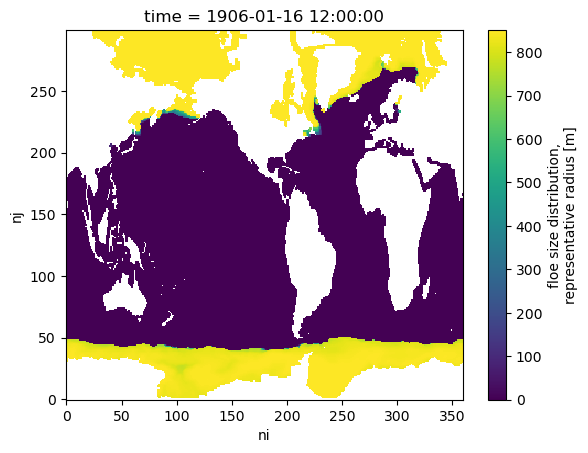

In [91]:
ds.isel(time=0).plot()
plt.show()

In [33]:
# # ds.isel(time=-1).plot()
# %matplotlib inline
# # ds
# if hemisphere == "south":
#         projection = ccrs.SouthPolarStereo(true_scale_latitude=-70)
#         lat_limits = [-90, -45]
# elif hemisphere == "north":
#     projection = ccrs.NorthPolarStereo(true_scale_latitude=70)
#     lat_limits = [45, 90]
# else:
#     raise ValueError("Invalid hemisphere. Choose 'north' or 'south'.")

# fig, ax = plt.subplots(
#                      subplot_kw={'projection': projection},
#                      gridspec_kw={'wspace': 0.1, 'hspace': 0.15}) 

# ax.set_extent([-180, 180, lat_limits[0], lat_limits[1]], crs=ccrs.PlateCarree())

# ds.isel(time=-1).plot(
#         ax = ax,
#         x="TLON",
#         y="TLAT",
#         # cmap=settings.get("cmap"),
#         # vmin=settings.get("vmin"),
#         # vmax=settings.get("vmax"),
#         transform=ccrs.PlateCarree(),
#     )
# # plt.show()

# Make a quick movie

In [60]:
from io import BytesIO
# import xarray as xr
import matplotlib

matplotlib.use("Agg")
import imageio.v3 as iio

plot_settings = {
    "aice": {"cmap": cmo.ice, "vmin": 0, "vmax": 1},
    "fsdrad": {"cmap": cmo.thermal, "vmin": 0, "vmax": 850},
    "hi": {"cmap": cmo.deep, "vmin": 0, "vmax": 5},
    "hs": {"cmap": cmo.amp, "vmin": 0, "vmax": 0.5},
    "hfs": {"cmap": cmo.amp, "vmin": 0, "vmax": 1},
    "tice": {"cmap": cmo.balance, "vmin": -30, "vmax": 0},
    "uvel": {"cmap": cmo.balance, "vmin": -0.5, "vmax": 0.5},
    "vvel": {"cmap": cmo.balance, "vmin": -0.5, "vmax": 0.5},
    "strength": {"cmap": cmo.matter, "vmin": 0, "vmax": 50e3},
    "divu": {"cmap": cmo.curl, "vmin": -1e-5, "vmax": 1e-5},
    "shear": {"cmap": cmo.curl, "vmin": 0, "vmax": 1e-5},
    "uocn": {"cmap": cmo.balance, "vmin": -0.5, "vmax": 0.5},
    "vocn": {"cmap": cmo.balance, "vmin": -0.5, "vmax": 0.5},
    "wave_sig_ht": {"cmap": cmo.tempo, "vmin": 0, "vmax": 10},  # Significant wave height
}

# Function to get plot settings for any variable
def get_plot_settings(var_name):
    # Remove common suffixes like "_m" (monthly), "_d" (daily), etc.
    base_var = re.sub(r"_(m|d|h|s|min|max|mean|std)$", "", var_name)
    
    # Check if the cleaned variable exists in settings
    return plot_settings.get(base_var, {"cmap": cmo.gray, "vmin": 0, "vmax": 1})  # Default if not found



def fancier_plot(ds_sel, time, var, hemisphere="south"):
    if hemisphere == "south":
        projection = ccrs.SouthPolarStereo(true_scale_latitude=-70)
        lat_limits = [-90, -45]
    elif hemisphere == "north":
        projection = ccrs.NorthPolarStereo(true_scale_latitude=70)
        lat_limits = [45, 90]
    else:
        raise ValueError("Invalid hemisphere. Choose 'north' or 'south'.")

    fig, ax = plt.subplots(
                         subplot_kw={'projection': projection},
                         gridspec_kw={'wspace': 0.1, 'hspace': 0.15})  # Adjust spacing

    # Add coastlines and land features
    land_50m = cft.NaturalEarthFeature('physical', 'land', '50m',
                                       edgecolor='black',
                                       facecolor='gray', linewidth=0.5)

    ax.set_global()
    ax.coastlines(resolution='50m')
    ax.add_feature(land_50m)
    ax.set_extent([-180, 180, lat_limits[0], lat_limits[1]], crs=ccrs.PlateCarree())

    # Get the settings for the selected variable, defaulting to None if not found
    settings = get_plot_settings(var)
    # print(settings.get("cmap"))
    # Apply the settings in the plot call
    ds_sel.plot(
        ax=ax,
        x="TLON",
        y="TLAT",
        cmap=settings.get("cmap"),
        vmin=settings.get("vmin"),
        vmax=settings.get("vmax"),
        transform=ccrs.PlateCarree(),
    )
    with BytesIO() as buf:
        fig.savefig(buf, format="png")
        plt.close(fig)
        image = iio.imread(buf.getvalue())
    return image



In [61]:
# ds_tmp["time"].values

In [62]:
# time = ds_tmp["time"].values[0]
# ds_tmp = ds.chunk({"time": 1, "ni": -1, "nj": -1})
# fancier_plot(ds_tmp.sel(time=time), time, var, hemisphere)

In [76]:
%%time
import calendar
month = 1

# var = "fsdrad_m"
hemisphere = "north"


# ice_mask = (ds.aice > 0.15).compute()
# southern_ocean_mask = (ds.TLAT < -50).compute()
# combined_mask = ((ds.aice > 0.15) & (ds.TLAT < -50)).compute() # Mask not working
# ds_tmp = ds.where(southern_ocean_mask, drop=True).copy()
ds_tmp = ds.chunk({"time": 1, "ni": -1, "nj": -1})

futures = [
    client.submit(fancier_plot, ds_tmp.sel(time=time), time, var, hemisphere) for time in ds_tmp["time"].values
]

with iio.imopen(f"access-om3-analysis/figures/{var}_{model}_{hemisphere}.gif", "w", extension=".gif") as f:
    for future in futures:
        image = future.result()
        f.write(image)



CPU times: user 2.23 s, sys: 418 ms, total: 2.64 s
Wall time: 4.34 s


In [19]:
# esm_datastore_filtered.to_dask()

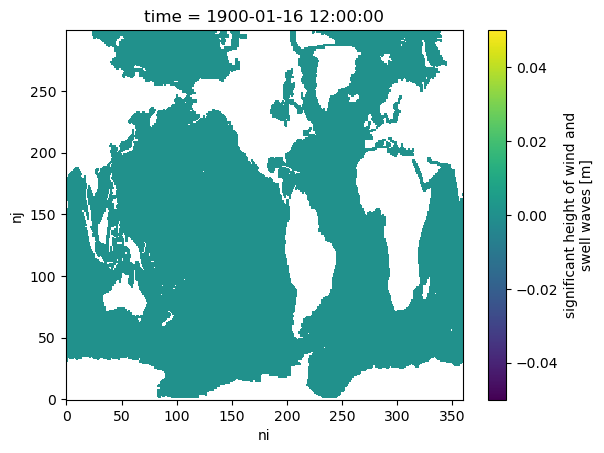

In [82]:
%matplotlib inline
ds.isel(time=0).plot()
plt.show()

In [81]:
plt.close()